#Head pose estimation

I/p images then get the landmarks of the face in this image then predict the Euler's angles(yaw, pitch and roll).

installing libraries

In [ ]:
%%capture
!pip install mediapipe

In [ ]:
%%capture
!pip install opencv-python

In [ ]:
%%capture
!pip install opencv-contrib-python

Importing libraries

In [ ]:
from google.colab import files
from google.colab import files
from sklearn.model_selection import train_test_split
import numpy as np
import os,cv2,math,glob,random
import scipy.io as sio
from math import cos, sin
import mediapipe
import warnings
from xgboost import XGBRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from sklearn.metrics import mean_absolute_error
from google.colab.patches import cv2_imshow
from fastai.imports import * #--->if there is any problem "path not defined"
warnings.filterwarnings('ignore')
from sklearn.model_selection import cross_val_score,GridSearchCV

In [ ]:
# Unzip the AFLW2000-3D dataset folder
%%capture
!unzip /content/AFLW2000-3D.zip

In [ ]:
files_without_extension=sorted([Path(f).stem for f in glob.glob("/content/AFLW2000/*.mat")])#files without extension.

In [ ]:
len(files_without_extension)

2000

In [ ]:
angles=[]#The three angles for each image
X_coordinate = []#for each landmark there is an x coordinate
Y_coordinate = []#for each landmark there is an y coordinate
Saved_files=[]
faceModule = mediapipe.solutions.face_mesh#how to detect the face in the image.
for file_name in files_without_extension:
  with faceModule.FaceMesh(static_image_mode=True) as faces:#'static_image_mode=True'---->Detection of the face
    image = cv2.imread('/content/AFLW2000/'+file_name+'.jpg')
    results = faces.process(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    if results.multi_face_landmarks != None:
          Saved_files.append(file_name) 
          face = results.multi_face_landmarks[0]
          X = []
          Y = []
          for landmark in face.landmark:
              shape = image.shape 
              x = landmark.x
              y = landmark.y
              new_x = int(x * shape[1])
              new_y = int(y * shape[0])
              X.append(new_x)#append x and y coordinates for all detected images in one array for each.
              Y.append(new_y)
          X = np.array(X)
          Y = np.array(Y)
          X_coordinate.append(X)
          Y_coordinate.append(Y)
          Files_mat = sio.loadmat('/content/AFLW2000/'+file_name+'.mat')#load .mat files for each image.
          pose_para = Files_mat["Pose_Para"][0][:3]#get the first three element in this vector wich are the labels(yaw,pitch,roll)-->o/p
          angles.append(pose_para)
X_coordinate = np.array(X_coordinate)
Y_coordinate= np.array(Y_coordinate)
angles = np.array(angles)   
X_coordinate.shape, Y_coordinate.shape,angles.shape

((1853, 468), (1853, 468), (1853, 3))

In [ ]:
pitch_angle = angles[:,0]
yaw_angle = angles[:,1]     #---->from the .mat files you will notice that Euler's angles are those first three numbers
roll_angle = angles[:,2]    #---->converting to numby arrays all of those to make it easier in slicing...

In [ ]:
pitch_angle.shape

(1853,)

In [ ]:
all_coordinates = np.concatenate([X_coordinate,Y_coordinate],axis=1)
all_coordinates.shape # Just for collecting x,y coordinates for each landmark 468x + 468y 

(1853, 936)

# usage of SVR 

#Normalize the data, without it i got very high error result

In [ ]:
X_nose = X_coordinate - X_coordinate[:,99].reshape((-1,1))#from the center of the face(nose)->subtract all x,y coordinates
Y_nose = Y_coordinate - Y_coordinate[:,99].reshape((-1,1)) 
X_171 = X_coordinate[:,171]#The top point on face
Y_171 = Y_coordinate[:,171]
X_10 = X_coordinate[:,10] #----->Chin point
Y_10 = Y_coordinate[:,10]
Shortest_distance = np.linalg.norm(np.array((X_10,Y_10)) - np.array((X_171,Y_171)),axis = 0).reshape(-1,1)
Normalized_X = X_nose /Shortest_distance
Normalized_Y = Y_nose /Shortest_distance
After_Norm_x = Normalized_X
After_Norm_y= Normalized_Y

In [ ]:
all_coordinates_Norm = np.concatenate([After_Norm_x,After_Norm_y],axis=1)
all_coordinates_Norm.shape # Just for collecting x,y coordinates for each landmark 468x + 468y

(1853, 936)

#Splitting data

In [ ]:
len(all_coordinates_Norm)

1853

In [ ]:
angles.shape

(1853, 3)

In [ ]:
X_train,X_validation,y_train,y_validation,Saved_files_train,Saved_files_test = train_test_split(all_coordinates_Norm,angles,Saved_files,test_size = 0.2,random_state = 15)

In [ ]:
#X_train,y_train,X_train,y_test = train_test_split(all_coordinates_Norm,angles,test_size = 0.2,random_state = 20)

In [ ]:
X_train.shape,X_train,shape

((1482, 936), array([[ 0.08764384, -0.01991905,  0.03983811, ..., -0.27488295,
         -0.42626776, -0.45415443],
        [ 0.04369187,  0.10922968,  0.05679944, ..., -0.27088962,
         -0.3451658 , -0.35390418],
        [ 0.05449884,  0.0461144 ,  0.05030662, ..., -0.26410974,
         -0.30603192, -0.31441636],
        ...,
        [ 0.04956313,  0.04956313,  0.05406887, ..., -0.22078121,
         -0.23880416, -0.24781564],
        [ 0.03607685,  0.05611955,  0.04810247, ..., -0.26857213,
         -0.32068314, -0.3367173 ],
        [ 0.00887409,  0.05324454,  0.04437045, ..., -0.19079292,
         -0.14642247, -0.15529656]]), (450, 450, 3))

In [ ]:
y_pitch = y_train[:,0]
y_yaw = y_train[:,1] #from the dataset this angles in this order to detect each angle before drawing axis
y_roll = y_train[:,2]

In [ ]:
svr = {'kernel':['linear', 'poly'],'C':[1,10,100]}
# grid search y_pitch
svr_model = SVR()
svr_pitch = GridSearchCV(estimator =svr_model,param_grid = svr)
svr_pitch.fit(X_train, y_pitch)
svr_pitch_final = svr_pitch.best_estimator_
print("Show the best choice : ",svr_pitch_final)
print("Error results from training: ",mean_absolute_error(svr_pitch_final.predict(X_train),y_pitch))

Show the best choice :  SVR(C=10, kernel='poly')
Error results from training:  0.09225814627738999


In [ ]:
svr = {'kernel':['linear', 'poly'],'C':[1,10,100]}
# grid search y_yaw
svr_model = SVR()
svr_yaw = GridSearchCV(estimator =svr_model,param_grid = svr)
svr_yaw.fit(X_train, y_yaw)
svr_yaw_final = svr_yaw.best_estimator_
print("Show the best choice : ",svr_yaw_final)
print("Error results from training: ",mean_absolute_error(svr_yaw_final.predict(X_train),y_yaw))

Show the best choice :  SVR(C=100, kernel='poly')
Error results from training:  0.0683403243114337


In [ ]:
svr = {'kernel':['linear', 'poly'],'C':[1,10,100]}
# grid search y_roll
svr_model = SVR()
svr_roll = GridSearchCV(estimator =svr_model,param_grid = svr)
svr_roll.fit(X_train, y_roll)
svr_roll_final = svr_roll.best_estimator_
print("Show the best choice : ",svr_roll_final)
print("Error results from training: ",mean_absolute_error(svr_roll_final.predict(X_train),y_roll))

Show the best choice :  SVR(C=10, kernel='poly')
Error results from training:  0.08127580068097706


#Draw the three axis for Euler's angles

In [ ]:
def draw_axis(img, pitch,yaw,roll, tdx=None, tdy=None, size = 100):

    yaw = -yaw
    if tdx != None and tdy != None:
        tdx = tdx
        tdy = tdy
    else:
        height, width = img.shape[:2]
        tdx = width / 2
        tdy = height / 2

    # X-Axis pointing to right. drawn in red
    x1 = size * (cos(yaw) * cos(roll)) + tdx
    y1 = size * (cos(pitch) * sin(roll) + cos(roll) * sin(pitch) * sin(yaw)) + tdy

    # Y-Axis | drawn in green
    #        v
    x2 = size * (-cos(yaw) * sin(roll)) + tdx
    y2 = size * (cos(pitch) * cos(roll) - sin(pitch) * sin(yaw) * sin(roll)) + tdy

    # Z-Axis (out of the screen) drawn in blue
    x3 = size * (sin(yaw)) + tdx
    y3 = size * (-cos(yaw) * sin(pitch)) + tdy

    cv2.line(img, (int(tdx), int(tdy)), (int(x1),int(y1)),(0,0,255),3)
    cv2.line(img, (int(tdx), int(tdy)), (int(x2),int(y2)),(0,255,0),3)
    cv2.line(img, (int(tdx), int(tdy)), (int(x3),int(y3)),(255,0,0),2)

    return img

#Choose a random image from the dataset to show results

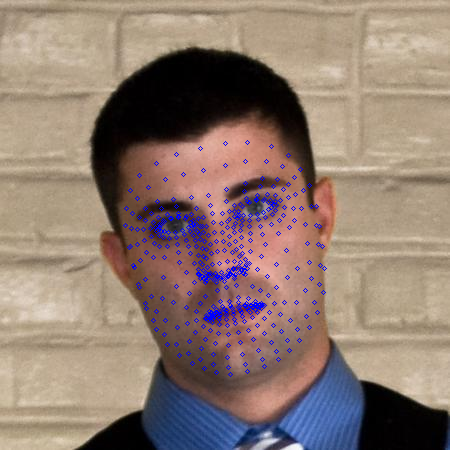

In [ ]:
random_file ='image00013'
faceModule = mediapipe.solutions.face_mesh
with faceModule.FaceMesh(static_image_mode=True) as face:
  image = cv2.imread('/content/AFLW2000/' + random_file + '.jpg')
  results = face.process(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
  if results.multi_face_landmarks != None:
    for face in results.multi_face_landmarks:
        for j,landmark in enumerate(face.landmark):
            x = landmark.x
            y = landmark.y
            x_shaped = int(x *450)
            y_shaped = int(y*450)
            cv2.circle(image, (x_shaped, y_shaped), radius=2, color=(255,0, 0))
    cv2_imshow(image)

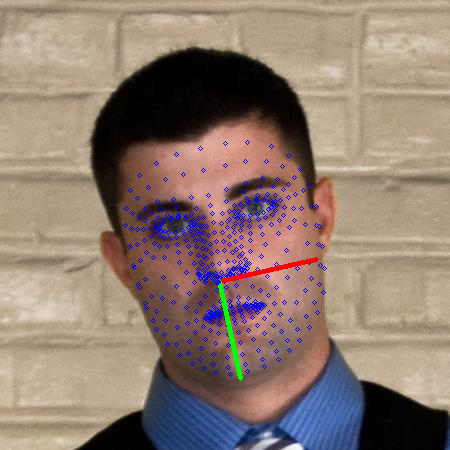

In [ ]:
mat_files = sio.loadmat('/content/AFLW2000/' + random_file + '.mat')
pitch_true = mat_files["Pose_Para"][0][0]
yaw_true = mat_files["Pose_Para"][0][1]
roll_true = mat_files["Pose_Para"][0][2]
cv2_imshow(draw_axis(image,pitch_true,yaw_true,roll_true,X[99],Y[99]))

#Testing level

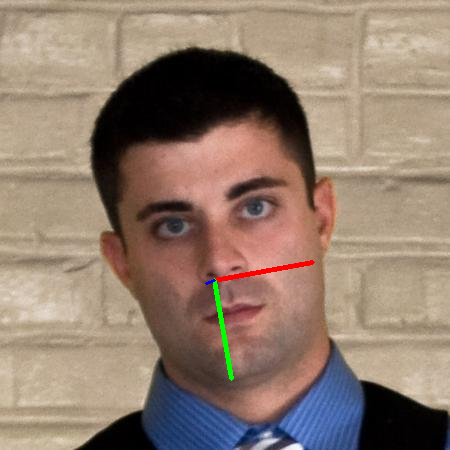

In [ ]:
#all of the above in one cell
faceModule = mediapipe.solutions.face_mesh
with faceModule.FaceMesh(static_image_mode=True) as face:
  img = cv2.imread('/content/AFLW2000/' + random_file + '.jpg')
  results = face.process(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
  if results.multi_face_landmarks != None:
    for face in results.multi_face_landmarks:
        X = []
        Y = []
        for j,landmark in enumerate(face.landmark):
            x = landmark.x
            y = landmark.y
            shape = img.shape 
            new_x = int(x * 450)
            new_y = int(y * 450)
            X.append(new_x)
            Y.append(new_y)
        X = np.array(X)
        Y = np.array(Y)
        X_center = X - X[99]
        Y_center = Y - Y[99]
        Short_distance = np.linalg.norm(np.array((X[171],Y[171])) - np.array((X[10],Y[10])))
        X_normalized = X_center/Short_distance
        Y_normalized = Y_center/Short_distance
        #points = np.concatenate([X_normalized,Y_normalized],axis=1).reshape(1,-1)
        points = np.hstack([X_normalized,Y_normalized]).reshape(1,-1)
        predicted_pitch = svr_pitch_final.predict(points)
        predicted_yaw = svr_yaw_final.predict(points)
        predicted_roll = svr_roll_final.predict(points)
        cv2_imshow(draw_axis(img,predicted_pitch,predicted_yaw,predicted_roll,X[99],Y[99]))

In [ ]:
def On_video(pitch_model,yaw_model,roll_model,smoothing = False,size =20):
  cap = cv2.VideoCapture('/content/video_mediapipe.mp4')
  width= int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
  height= int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
  img_array = []
  while(cap.isOpened()):   
      ret, img = cap.read()
      if ret == True:
        with faceModule.FaceMesh(static_image_mode=True) as face:
          results = face.process(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
          if results.multi_face_landmarks != None:
            for face in results.multi_face_landmarks:
                X = []
                Y = []
                for j,landmark in enumerate(face.landmark):
                    x = landmark.x
                    y = landmark.y
                    shape = img.shape 
                    new_x = int(x *450)
                    new_y = int(y *450)
                    X.append(new_x)
                    Y.append(new_y)
                X = np.array(X)
                Y = np.array(Y)
                X_nose = X - X[99]
                Y_nose = Y - Y[99]
                Shortest_distance = np.linalg.norm(np.array((X[171],Y[171])) - np.array((X[10],Y[10])))
                X_normalized = X_nose/Shortest_distance
                Y_normalized = Y_nose/Shortest_distance
                features = np.hstack([X_normalized ,Y_normalized]).reshape(1,-1)
                prediction_of_pitch = pitch_model.predict(features)
                prediction_of_yaw = yaw_model.predict(features)
                prediction_of_roll = roll_model.predict(features)
                draw_axis(img,prediction_of_pitch,prediction_of_yaw,prediction_of_roll,X[1],Y[1])
                img_array.append(img)
      else: 
          break
  cap.release()  
  cv2.destroyAllWindows()
  result = cv2.VideoWriter('video_result.mp4',cv2.VideoWriter_fourcc(*'DIVX'), 15, (width,height))
  for i in range(len(img_array)):
    result.write(img_array[i])
  result.release()

In [ ]:
On_video(svr_pitch_final,svr_yaw_final,svr_roll_final,smoothing = True,size = 20)

In [ ]:
files.download('/content/video_result.mp4')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>